# <center>用随机森林模型预测AB3类化合形成能</center>

## 1. 数据提取

#### 从Materials Project库中提取AB3化合物，其中B元素被限制为F、Cl、Br、I、O、S这几种元素

In [22]:
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval  
import pandas as pd
mpdr = MPDataRetrieval('FVdCyM5w7RKmqkQW') #mpdr = MPDataRetrieval('API_keys')，API_keys可以通过在 materialsproject.org 注册账号获取。
df = mpdr.get_dataframe(criteria={'elements':{'$in':['F', 'Cl', 'Br','I','O','S']}
                                  , 'formula_anonymous':"AB3"}      #mpquery方法参见https://github.com/materialsproject/mapidoc 
                        ,properties=["material_id"
                                     ,"composition"
                                     ,"pretty_formula"     
                                     ,"structure"
                                     ,"formation_energy_per_atom"
                                     ,"formula"])
df.head()

,composition,pretty_formula,structure,formation_energy_per_atom,formula
material_id,,,,,
mp-984358,None,Au3O,"[[5.36992525 1.20568891 2.20134615] Au, [2.088...",0.189155,"{'Au': 3.0, 'O': 1.0}"
mp-942,None,AuF3,"[[2.89648068 2.13894096 2.69806481] F, [2.0230...",-1.332780,"{'F': 3.0, 'Au': 1.0}"
mp-983458,None,Tl3Cl,[[-2.26566077e-04 1.99943127e+00 1.54093564e...,-0.479436,"{'Tl': 3.0, 'Cl': 1.0}"
mp-9371,None,ErF3,"[[1.6531378 0.98950681 2.98949123] F, [4.0229...",-4.492670,"{'F': 3.0, 'Er': 1.0}"
mp-974386,None,Rh3F,[[-2.02634214e-16 2.05320805e+00 1.60987156e...,0.093761,"{'Rh': 3.0, 'F': 1.0}"


#### 这里我们只需要formation_energy_per_atom和pretty_formula两列

In [23]:
df= df[["formation_energy_per_atom","pretty_formula"]]
df.head()

,formation_energy_per_atom,pretty_formula
material_id,,
mp-984358,0.189155,Au3O
mp-942,-1.332780,AuF3
mp-983458,-0.479436,Tl3Cl
mp-9371,-4.492670,ErF3
mp-974386,0.093761,Rh3F


#### 对列进行重新命名，让后面流程显得更加直观

In [24]:
df = df.rename(columns={'pretty_formula':'composition','formation_energy_per_atom':'formation_energy'})
df.head()

,formation_energy,composition
material_id,,
mp-984358,0.189155,Au3O
mp-942,-1.332780,AuF3
mp-983458,-0.479436,Tl3Cl
mp-9371,-4.492670,ErF3
mp-974386,0.093761,Rh3F


## 2. 生成训练集(数据预处理）

#### 记下来我们仅仅保留每个化合物形成能最低的entry，数据库中提取的化合物的形成能可能不唯一，可能存在多个enrty

#### matminer可以通过化学组分来得到输入数据进行特征化处理

#### 第一步需要将表示化学组分的composition列转换成pymatgen Composition object

In [4]:
from matminer.featurizers.conversions import StrToComposition
df = StrToComposition(target_col_id='composition_obj').featurize_dataframe(df, 'composition')
df.head()

,formation_energy,composition,composition_obj
material_id,,,
mp-984358,0.189155,Au3O,"(Au, O)"
mp-942,-1.332780,AuF3,"(Au, F)"
mp-983458,-0.479436,Tl3Cl,"(Tl, Cl)"
mp-9371,-4.492670,ErF3,"(Er, F)"
mp-974386,0.093761,Rh3F,"(Rh, F)"


#### 移除不存在形成能的entry

In [5]:
#for k in ['formation_energy_per_atom']: 
#    df[k] = pd.to_numeric(df[k])
original_count = len(df)
df = df[~ df['formation_energy'].isnull()]
print('Removed %d/%d entries'%(original_count - len(df), original_count))  #会发现没有减少entry

Removed 0/690 entries


#### 仅仅保留每个化合物的基态entry，使得最终每个化合物仅仅有一个entry

In [6]:
%%time
original_count = len(df)
df['composition'] = df['composition_obj'].apply(lambda x: x.reduced_formula)
df.sort_values('formation_energy', ascending=True, inplace=True)
df.drop_duplicates('composition', keep='first', inplace=True)
print('Removed %d/%d entries'%(original_count - len(df), original_count))

Removed 289/690 entries
Wall time: 89.6 ms


#### 移除异常值

In [7]:
import numpy as np
original_count = len(df)
df = df[np.logical_and(df['formation_energy'] >= -20, df['formation_energy'] <= 5)]
print('Removed %d/%d entries'%(original_count - len(df), original_count))

Removed 0/401 entries


## 3. 搭建随机森林模型

#### 3.1 计算表示（representation）

#### 搭建模型的第一步是将原始(raw)的材料数据转换成数值属性(attributes)列表,才能别模型使用

In [8]:
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])

#### 计算特征(feature)

In [9]:
feature_labels = feature_calculators.feature_labels()
df = feature_calculators.featurize_dataframe(df, col_id='composition_obj')
print('Generated %d features'%len(feature_labels))
print('Training set size:', 'x'.join([str(x) for x in df[feature_labels].shape]))


Generated 145 features
Training set size: 401x145


#### 移除含有NaN和infinite的特征

In [10]:
original_count = len(df)
df = df[~ df[feature_labels].isnull().any(axis=1)]
print('Removed %d/%d entries'%(original_count - len(df), original_count))

Removed 0/401 entries


#### 3.2 调整模型超参数

In [11]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit, KFold
model = GridSearchCV(RandomForestRegressor(n_estimators=100,random_state=0 ),#决策树的个数为10
                     param_grid=dict(max_features=range(8,15)),
                     scoring='neg_mean_squared_error',cv=ShuffleSplit(n_splits=1, test_size=0.2))
    #test_size=0.5表示用多少数据做为模型的训练集       
    #用GridSearchCV进行自动调参，只要把参数输进去，就能给出最优化的结果和参数，该方法适用于小数据集合

#### 进行训练

In [12]:
model.fit(df[feature_labels], df['formation_energy'])

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': range(8, 15)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

#### 得到调参结果

In [13]:
model.best_score_

-0.18295057854305657

AttributeError: 'RandomForestRegressor' object has no attribute 'cv_results_'

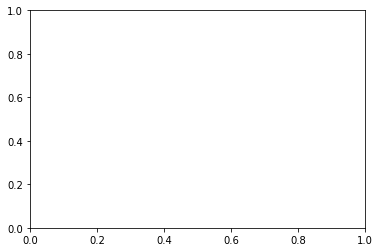

In [21]:
from matplotlib import pyplot as plt
import numpy as np
fig, ax = plt.subplots()

# Plot the score as a function of alpha
ax.scatter(model.cv_results_['param_max_features'].data,
          np.sqrt(-1 * model.cv_results_['mean_test_score']))
ax.scatter([model.best_params_['max_features']], np.sqrt([-1*model.best_score_]), marker='o', color='r', s=40)
ax.set_xlabel('Max. Features')
ax.set_ylabel('RMSE (eV/atom)')

#### 保存最佳模型

In [15]:
model = model.best_estimator_

## 3.3交叉验证

#### 通过十折交叉验证来量化得出模型的表现

In [16]:
cv_prediction = cross_val_predict(model, df[feature_labels], df['formation_energy'], cv=KFold(10, shuffle=True))

#### 计算汇总数据

In [17]:
for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
    score = getattr(metrics,scorer)(df['formation_energy'], cv_prediction)
    print(scorer, score)

r2_score 0.8875149350353158
mean_absolute_error 0.2556670244403457
mean_squared_error 0.1771888802515107


In [18]:
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=None, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

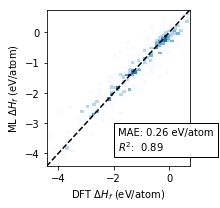

In [19]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()

ax.hist2d(pd.to_numeric(df['formation_energy']), cv_prediction, norm=LogNorm(), bins=64, cmap='Blues', alpha=0.9)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_xlim())

mae = metrics.mean_absolute_error(df['formation_energy'], cv_prediction)
r2 = metrics.r2_score(df['formation_energy'], cv_prediction)
ax.text(0.5, 0.1, 'MAE: {:.2f} eV/atom\n$R^2$:  {:.2f}'.format(mae, r2),
        transform=ax.transAxes,
       bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax.set_ylabel('ML $\Delta H_f$ (eV/atom)')

fig.set_size_inches(3, 3)
fig.tight_layout()
fig.savefig('oqmd_cv.png', dpi=320)

#### 特征重要程度比较

In [20]:
feature_importance = model.feature_importances_
feature_importance

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.93730003e-03, 3.70384280e-03,
       2.48542418e-03, 4.52772363e-03, 2.83426018e-03, 1.63973336e-02,
       1.19334392e-02, 2.06727233e-03, 5.94798179e-03, 9.31369315e-03,
       6.40088023e-03, 2.15434440e-02, 1.95413997e-03, 2.78457127e-03,
       4.29844356e-03, 4.31299547e-03, 3.25009575e-03, 1.19244908e-02,
       5.19311494e-03, 5.74531256e-03, 9.48429879e-03, 1.34147560e-02,
       7.47227915e-03, 4.28622206e-02, 1.07335558e-02, 4.82177443e-04,
       8.86548161e-03, 2.28382766e-02, 8.78038543e-03, 2.76914435e-02,
       3.12741412e-04, 2.01907407e-03, 1.74027561e-03, 2.68072527e-03,
       3.04380640e-03, 1.50497268e-02, 7.76932135e-03, 9.01432504e-03,
       2.05216178e-02, 5.77525580e-03, 3.04205020e-02, 5.14337800e-02,
       1.72465379e-02, 1.34546848e-02, 3.13067100e-02, 3.30519341e-02,
       4.73359002e-02, 4.39138186e-02, 5.91213571e-04, 0.00000000e+00,
      